In [1]:
from ML_Preparation.Preprocessing_M import DataExtractor, DataPreprocessing

de = DataExtractor("D:/hka-aqm-m", "C:/Users/danie/building_M_data")

df = de.create_df()

No .dat files found in C:/Users/danie/building_M_data. 
 Trying to extract files from the original directory D:/hka-aqm-m
Read data successfully.
Data contains 979166 data points and 18 columns.


In [2]:
label = "CO2"

dp = DataPreprocessing(label = label)

df_preprocessed = dp.preprocess_df(df, rolling_window = "3d", sample_time = "1d")

Number of outliers detected: -73438
Number of normal samples detected: 905728


In [3]:
df_preprocessed.columns

Index(['date_time', 'tmp', 'hum', 'CO2', 'VOC', 'vis', 'IR', 'BLE', 'rssi',
       'snr', 'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres',
       'room_number', 'time_diff_sec', 'tmp_diff', 'hum_diff', 'VOC_diff',
       'vis_diff', 'IR_diff', 'BLE_diff', 'tavg_diff', 'tmin_diff',
       'tmax_diff', 'prcp_diff', 'wdir_diff', 'wspd_diff', 'wpgt_diff',
       'pres_diff', 'year', 'dayofweek', 'hour', 'season', 'color',
       'VOC_CO2_ratio'],
      dtype='object')

In [4]:
from ML_Preparation.Feature_Engineering import *

fe = FeatureEngineering(df_preprocessed.drop(columns = ["VOC_CO2_ratio"
                                                        #"tmp", "hum", "VOC", "vis", "IR",
                                                        #"tmax", "tmin", "tavg", "wdir", "wspd",
                                                        ]), 
                        label = label, 
                        categorical_features = ["season", "room_number", "dayofweek", "color"],
                        automated_feature_engineering = False)

X_train, y_train, X_test, y_test = fe.feature_engineering(skip_scale = True)

In [5]:
X_train.columns

Index(['year', 'hour', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'room_number_m001', 'room_number_m002',
       'room_number_m003', 'room_number_m004', 'room_number_m101',
       'room_number_m102', 'room_number_m103', 'room_number_m104',
       'room_number_m105', 'room_number_m113', 'room_number_m201',
       'room_number_m202', 'room_number_m206', 'room_number_m207',
       'room_number_m209', 'room_number_m216', 'room_number_m301',
       'room_number_m302', 'room_number_m303', 'room_number_m304',
       'room_number_m306', 'room_number_m310', 'room_number_m700',
       'room_number_mu04', 'room_number_mu06', 'room_number_mu10',
       'room_number_mu11', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6',
       'color_green', 'color_red', 'color_red_blinking', 'color_yellow', 'tmp',
       'hum', 'VOC', 'vis', 'IR', 'BLE', 'tavg', 'tmin', 'tmax', 'prcp',
       'wdir', 'wspd', 'wpgt', 'pres

In [6]:
df_train = fe.X_train
df_train[label] = fe.y_train

df_test = fe.X_test
df_test[label] = fe.y_test

In [7]:
def transform_data_for_forecasting(data, label_name, n_in, n_out, dropna = True):
    n_vars = data.shape[1]

    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data[[f"{label_name}"]].shift(-i))
        if i == 0:
            names += [f"{label_name}(t)"]
        else:
            names += [f"{label_name}(t+{i})"]
        # put it all together
        data_reframed = pd.concat(cols, axis=1)
        data_reframed.columns = names
        # drop rows with NaN values
        if dropna:
            data_reframed.dropna(inplace=True)

    return data_reframed

In [8]:
n_out = 2

train_reframed = transform_data_for_forecasting(df_train, label, 1, n_out)
test_reframed = transform_data_for_forecasting(df_test, label, 1, n_out)

train_reframed

,year(t-1),hour(t-1),season_fall(t-1),season_spring(t-1),season_summer(t-1),season_winter(t-1),room_number_m001(t-1),room_number_m002(t-1),room_number_m003(t-1),room_number_m004(t-1),...,tmin_diff(t-1),tmax_diff(t-1),prcp_diff(t-1),wdir_diff(t-1),wspd_diff(t-1),wpgt_diff(t-1),pres_diff(t-1),CO2(t-1),CO2(t),CO2(t+1)
date_time,,,,,,,,,,,,,,,,,,,,,
2022-06-03,1.0,0.0,False,False,True,False,True,False,False,False,...,50.447993,50.447993,0.0,-50.447993,50.447993,50.447993,50.447993,538.500000,538.500000,503.500000
2022-06-04,1.0,0.0,False,False,True,False,True,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,538.500000,503.500000,515.288618
2022-06-20,1.0,0.0,False,False,True,False,True,False,False,False,...,50.447993,50.447993,0.0,-50.447993,50.447993,50.447993,50.447993,503.500000,515.288618,507.570571
2022-06-21,1.0,0.0,False,False,True,False,False,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,515.288618,507.570571,508.663311
2022-06-22,1.0,0.0,False,False,True,False,False,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,507.570571,508.663311,502.070474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-29,2.0,0.0,False,False,True,False,False,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,435.445850,593.054711,401.047590
2023-06-29,2.0,0.0,False,False,True,False,False,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,593.054711,401.047590,455.350129
2023-06-29,2.0,0.0,False,False,True,False,False,False,False,False,...,-0.019822,-0.019822,0.0,0.019822,-0.019822,-0.019822,-0.019822,401.047590,455.350129,473.533333


In [9]:
df_train.tail()["CO2"]

date_time
2023-06-29    401.047590
2023-06-29    455.350129
2023-06-29    473.533333
2023-06-29    428.072165
2023-06-29    709.895390
Name: CO2, dtype: float64

In [10]:
from sklearn.preprocessing import StandardScaler

def transform_to_numpy_array(train_data, test_data, n_out):
    # split into train and test sets
    values_train = train_data.values
    values_test = test_data.values
    # split into input and outputs
    train = values_train[:, :]
    test = values_test[:, :]

    train_X, train_y = train[:, :-n_out], train[:, -n_out:]
    test_X, test_y = test[:, :-n_out], test[:, -n_out:]

    sc = StandardScaler()

    train_X = sc.fit_transform(train_X)
    test_X = sc.transform(test_X)

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

    train_X = np.asarray(train_X).astype('float32')
    train_y = np.asarray(train_y).astype('float32')

    test_X = np.asarray(test_X).astype('float32')
    test_y = np.asarray(test_y).astype('float32')

    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = transform_to_numpy_array(train_reframed, test_reframed, n_out)


(5090, 1, 73) (5090, 2) (1271, 1, 73) (1271, 2)


In [11]:
train_X.shape

(5090, 1, 73)

Epoch 1/10


c:\Users\danie\anaconda3\envs\awp1\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



80/80 - 2s - 28ms/step - loss: 56263.3750
Epoch 2/10
80/80 - 0s - 2ms/step - loss: 38034.6289
Epoch 3/10
80/80 - 0s - 2ms/step - loss: 38313.1680
Epoch 4/10
80/80 - 0s - 2ms/step - loss: 41226.7617
Epoch 5/10
80/80 - 0s - 2ms/step - loss: 38057.2344
Epoch 6/10
80/80 - 0s - 1ms/step - loss: 36870.1328
Epoch 7/10
80/80 - 0s - 1ms/step - loss: 38284.3320
Epoch 8/10
80/80 - 0s - 1ms/step - loss: 34945.0391
Epoch 9/10
80/80 - 0s - 1ms/step - loss: 33819.4375
Epoch 10/10
80/80 - 0s - 1ms/step - loss: 34203.5586


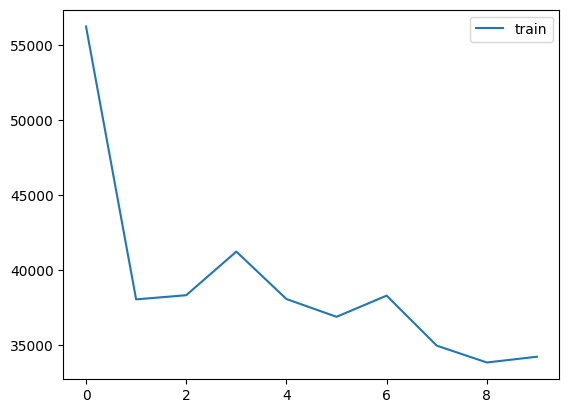

In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Dropout, Bidirectional
from keras.optimizers import Adam, SGD
from matplotlib import pyplot

class MyLSTMModel:
    def __init__(self,
                 n_out, 
                 lstm_units=100,
                 input_shape=(None, train_X.shape[-1]),
                 ):
        self.model = Sequential()
        self.model.add(LSTM(units=lstm_units, input_shape=input_shape, return_sequences = True, recurrent_dropout = 0.3))
        self.model.add(Dropout(0.3))
        self.model.add(Bidirectional(LSTM(units=lstm_units, recurrent_dropout = 0.3)))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(50, activation = "relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(30, activation = "relu"))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(n_out))

        self.model.compile(optimizer=Adam(learning_rate = 0.1), loss='mse')
    
    def summary(self):
        self.model.summary()

# Instantiate the model
my_model = MyLSTMModel(n_out)

history = my_model.model.fit(train_X, train_y, epochs=10, batch_size=64, 
                             #validation_data=(test_X, test_y), 
                             verbose=2, 
                             #shuffle=False
                             )

pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [22]:
pred = my_model.model.predict(test_X)

pred

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([[426.90405, 428.24896],
       [446.43176, 446.47223],
       [394.25897, 396.08545],
       ...,
       [527.1474 , 530.95685],
       [428.72266, 431.50098],
       [605.46234, 608.53784]], dtype=float32)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
import plotly.express as px
import seaborn as sns


class Evaluator:

    def __init__(self):
        pass

    def evaluate(self, y_pred, y_true):
        print("MSE: ", self.calculate_mse(y_pred = y_pred, y_true = y_true))
        print("RMSE: ", self.calculate_rmse(y_pred = y_pred, y_true = y_true))
        print("MAPE: ", self.calculate_mape(y_pred = y_pred, y_true = y_true))
        print("R2: ", self.calculate_r2(y_pred = y_pred, y_true = y_true))
        print("\n")


    def calculate_mse(self, y_true, y_pred):
        return round(mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_rmse(self, y_true, y_pred):
        return round(root_mean_squared_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_mape(self, y_true, y_pred):
        return round(mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred), 2)

    def calculate_r2(self, y_true, y_pred):
        return round(r2_score(y_true = y_true, y_pred = y_pred), 2)

ev = Evaluator()

for col in range(0, test_y.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = test_y[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = test_y[:, col]

    px.line(y = [test_y[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()


t + 0
MSE:  8487.73
RMSE:  92.13
MAPE:  0.12
R2:  -0.71




t + 1
MSE:  8365.2
RMSE:  91.46
MAPE:  0.12
R2:  -0.67




In [25]:
pred = my_model.model.predict(train_X)

for col in range(0, train_y.shape[1]):
    print(f"t +", col)
    ev.evaluate(y_true = train_y[:, col], y_pred = pred[:, col])

    pred_df = pd.DataFrame(pred[:, col], columns = [f"pred_CO2(t + {col})"])
    pred_df[f"CO2(t + {col})"] = train_y[:, col]

    px.line(y = [train_y[:, col], pred[:, col]], title = f"Prediction for CO2(t + {col})      blue = y_true, red = y_pred").show()

160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
t + 0
MSE:  19357.67
RMSE:  139.13
MAPE:  0.15
R2:  0.37




t + 1
MSE:  19214.17
RMSE:  138.62
MAPE:  0.15
R2:  0.37


